Set up environment

In [6]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [11]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [21]:
sim_args = copy(default_args)
sim_args.update({'W': np.array([[-.5, .4, 0], [.2, -.5, .3], [0, 0, -.5]]),
                'nodespercommunity': 1})
sim_args

{'bottomup': False,
 'dt': 0.5,
 'ea': 200,
 'g': 1,
 'hubnetwork_dsity': 0.25,
 'I': None,
 'innetwork_dsity': 0.6,
 'iv': 400,
 'local_com': 1,
 'ncommunities': 3,
 'noise': None,
 'noise_loc': 0,
 'noise_scale': 0,
 'nodespercommunity': 1,
 'outnetwork_dsity': 0.08,
 'plot_network': False,
 'plot_task': False,
 's': 0.8,
 'sa': 100,
 'showplot': False,
 'standardize': False,
 'stim_mag': 0.5,
 'stimsize': 3,
 'taskdata': None,
 'tasktiming': None,
 'tau': 1,
 'Tmax': 1000,
 'topdown': True,
 'W': array([[-0.5,  0.4,  0. ],
        [ 0.2, -0.5,  0.3],
        [ 0. ,  0. , -0.5]])}

<AxesSubplot:>

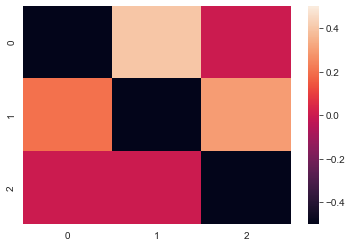

In [24]:
sns.heatmap(sim_args['W'], vmin = -0.5, vmax = 0.5)

# Generate time series

## Resting

In [17]:
rest_data, _ = networkModel(sim_args['W'], args_dict=sim_args)

## Task

### Task 1: Long, infrequent, single node


### Task 2: Short, frequent, single node



### Task 3: Short, frequent, alternating nodes

# Compute FC connectivity matrices

## Pearson

## Multiple regression